Copyright Preferred Computational Chemistry, Inc. as contributors to Matlantis contrib project

# BaTiO3の相転移解析（Tetragonal → Cubic）

ペロブスカイト構造で知られるBaTiO3は約4ooK において結晶対称性がtetragonalからcubicに相転移することが知られています。  
2つの構造の違いを格子定数と動径分布関数（RDF）から比較し、実際にNPTアンサンブルMDで相転移が生じることを確認します。  
Keyword : 相転移、NPT、RDF

In [ ]:
!pip install pfp_api_client
!pip install pandas joblib

# # 初回使用時のみ、ライブラリのインストールをお願いします。

In [1]:
import os, sys,csv,glob,shutil,re,time
from collections import OrderedDict

# PFP
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator
estimator = Estimator()
calculator = ASECalculator(estimator)

# ASE
import ase
from ase.io import read,write,Trajectory
from ase import Atoms, Atom
from ase.constraints import FixAtoms, FixedPlane, FixBondLengths 
from ase.build import bulk
from ase.visualize import view
from ase.build import surface
from ase.constraints import StrainFilter,ExpCellFilter
from ase.optimize import BFGS,FIRE,MDMin
from ase.geometry.analysis import Analysis
from ase.md.nptberendsen import Inhomogeneous_NPTBerendsen
from ase.md import MDLogger
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary
from ase.md.verlet import VelocityVerlet
from ase import units


# Other external packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import itertools
import json
from IPython.display import Image, display_png
import nglview as nv
import ipywidgets as widgets
from joblib import Parallel, delayed


try:
    dir_path = Path(__file__).parent
except:
    dir_path = Path("").resolve()

# definition of input and output directries
inp="./input/"
out="./output/"

In [2]:
# 少しずつ変位幅を減らしながら格子定数最適化を複数回繰り返して構造が真に収束したか確認します
def opt_cell_size(m,sn = 10, iter_count = False): # m:Atomsオブジェクト
    m.set_constraint() # clear constraint
    m.set_calculator(calculator)
    maxf = np.sqrt(((m.get_forces())**2).sum(axis=1).max()) # √(fx^2 + fy^2 + fz^2)の一番大きいものを取得
    ucf = ExpCellFilter(m)
    print("ini   pot:{:.4f},maxforce:{:.4f}".format(m.get_potential_energy(),maxf))
    de = -1 
    s = 1
    ita = 100
    while ( de  < -0.01 or de > 0.01 ) and s <= sn :
        opt = BFGS(ucf,maxstep=0.04*(0.9**s),logfile=None)
        old  =  m.get_potential_energy() 
        opt.run(fmax=0.005,steps =ita)
        maxf = np.sqrt(((m.get_forces())**2).sum(axis=1).max())
        de =  m.get_potential_energy()  - old
        print("{} pot:{:.4f},maxforce:{:.4f},delta:{:.4f}".format(s*ita,m.get_potential_energy(),maxf,de))
        s += 1
    if iter_count == True:
        return m, s*ita
    else:
        return m

## 初期構造（Materials Project）の確認

Tetragonal, Cubic 各構造は次の通りMaterials Projectより取得しました。  
Tetragonal : [mp-5986](https://materialsproject.org/materials/mp-5986/)   
Cubic : [mp-2998](https://materialsproject.org/materials/mp-2998/)   
Licensed under CC BY 4.0

In [3]:
# Tetragonal structure
bto_tetra = read(inp+"BaTiO3_mp-5986_computed.cif")
bto_tetra = opt_cell_size(bto_tetra)
v = view(bto_tetra, viewer='ngl')
v.view.add_representation("ball+stick")
display(v)

ini   pot:-31.1870,maxforce:0.3099
100 pot:-31.1990,maxforce:0.0006,delta:-0.0120
200 pot:-31.1990,maxforce:0.0006,delta:-0.0000


In [4]:
# Cubic structure
bto_cubic = read(inp+"BaTiO3_mp-2998_computed.cif")
bto_cubic = opt_cell_size(bto_cubic)
v = view(bto_cubic, viewer='ngl')
v.view.add_representation("ball+stick")
display(v)

ini   pot:-31.1468,maxforce:0.0000
100 pot:-31.1470,maxforce:0.0000,delta:-0.0002


### 格子定数と動径分布関数の取得

構造の比較のため、格子定数とRDFを取得します。  
RDFはase.geometry.analysisのAnalysisクラスから取得が可能です。  
使用する [get_rdf 関数](https://wiki.fysik.dtu.dk/ase/ase/geometry.html?highlight=rdf#ase.geometry.analysis.Analysis.get_rdf)の変数は次の通りです。
- rmax: RDFプロット範囲最大値（Å）。この値の2倍がセルサイズを超えてはいけない。
- nbins: ヒストグラムのビン数。出力はこの数の一次元array形式となる。
- elements: 元素種の指定。デフォルトでは全元素を指定。例えば["C", "O"]などのリスト表記などで特定の元素を抽出できる。

Cubic : CUB(a=4.03842)
Tetragonal : TET(a=3.9859, c=4.28734)


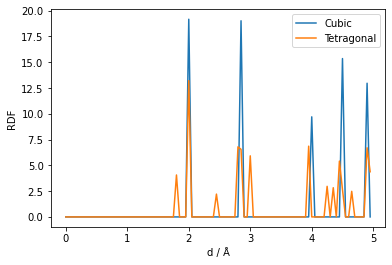

In [5]:
bto_list = [bto_cubic, bto_tetra]
tags = ["Cubic", "Tetragonal"]
rmax = 5
nbins = 100
delta = [(rmax/nbins)*i for i in range(nbins)]
for bto, name in zip(bto_list, tags):
    atoms = bto.copy()
    print(name, ":",atoms.cell.get_bravais_lattice())
    atoms *= (4,4,4)
    ana = Analysis(atoms)
    rdf = ana.get_rdf(rmax,nbins,elements=["Ti","O"])[0]
    plt.plot(delta, rdf, label=name)
plt.xlabel("d / Å")
plt.ylabel("RDF")
plt.legend()
plt.show()

## MDによる解析

MD計算においては、結晶対称性が変化するためにInhomogeneous NPTアンサンブルを用います。  
基本的な使い方はNPT Berensenと同様です。  
また、制御温度を単調に上昇させるクラスを導入しdynに加えています。  
これにより300K → 600K にシミュレーションを通して徐々に温度が上昇していきます。

In [6]:
def convert_atoms_to_upper(atoms: Atoms) -> Atoms:
    atoms2 = atoms.copy()
    
    # cell "c" -> z-axis
    atoms2.rotate(atoms2.cell[2], (0, 0, 1), rotate_cell=True)

    # cell "b" -> yz-plane
    bx, by, bz = atoms2.cell[1, :]
    angle = 90.0 - np.rad2deg(np.arctan2(by, bx))
    atoms2.rotate(angle, 'z', rotate_cell=True)
    # [Note] cell "a" can be arbitrary.

    # supress numerical precision, lower triangular values must be 0.0.
    atoms2.cell = np.where(np.abs(atoms2.cell) < 1e-10, 0.0, atoms2.cell)

    # Check that cell is uppper triangular form.
    m = atoms2.cell
    assert m[1, 0] == m[2, 0] == m[2, 1] == 0.0, f"cell {m} is not upper triangular!"
    return atoms2

### MD計算の実行

In [7]:
#NPT ensamble MD with constant Temperature rising
atoms = bto_tetra.copy()
atoms *=(4,4,4)
atoms = convert_atoms_to_upper(atoms)
atoms.set_calculator(calculator)
os.makedirs(out, exist_ok=True)
tag = out+"BaTiO3_tetragonal_NPT"


mass = 137.33 + 47.867 + 15.999*3
Navo = 6.022
N_atom = 64

dt = 1.0
steps = 100000
temp = 300.0
temp_end = 600.0

# Set the momenta corresponding to T(K).
MaxwellBoltzmannDistribution(atoms, temp * units.kB)
# Sets the center-of-mass momentum to zero.
Stationary(atoms)

# Run MD by NPT
dyn = Inhomogeneous_NPTBerendsen(atoms, timestep=dt * units.fs, temperature_K=temp,
                   taut=100 * units.fs, pressure_au=1.01325 * units.bar,
                   taup=1000 * units.fs, compressibility_au=4.57e-5 / units.bar,
                                logfile=tag + '.log', trajectory=tag + ".traj")


#vol = atoms.get_volume() * 1e-3
rho_volinv = 10 * N_atom * mass / (Navo)
def print_dyn():
    print(f"Dyn  step: {dyn.get_number_of_steps(): >5}, energy: {atoms.get_total_energy():.4f}, density: {rho_volinv/(atoms.get_volume()*1e-3):5.3f}")


dyn.attach(print_dyn, interval=100)

dyn.attach(MDLogger(dyn, atoms, tag+'_md.log', header=True, stress=True,
           peratom=True, mode="w"), interval=100)
class MyMDLogger(MDLogger): 
    def __call__(self):

        dat = f"Dyn  step: {self.dyn.get_number_of_steps(): >5}, "
        dat += f"energy: {self.atoms.get_total_energy():.4f}, "
        dat += f"density: {rho_volinv/(self.atoms.get_volume()*1e-3):5.3f}, "
        dat += f"cell: {self.atoms.cell.cellpar()[0:6]}\n"

        self.logfile.write(dat)
        self.logfile.flush()

dyn.attach(MyMDLogger(dyn, atoms, tag+'_mymdlogger.log', header=False, stress=True,
           peratom=True, mode="w"), interval=100)

class Change_temp:
    def __init__(self, dyn, temp_ini, temp_end, steps):
        self.dyn = dyn
        self.delta = (temp_end - temp_ini)/steps
    def __call__(self):
        self.dyn.temperature += self.delta
    
dyn.attach(Change_temp(dyn, temp, temp_end, steps))

dyn.run(steps)

/home/jovyan/.local/lib/python3.7/site-packages/ase/md/md.py:48: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


Dyn  step:     0, energy: -1984.5833, density: 5685.069
Dyn  step:   100, energy: -1979.8720, density: 5611.623
Dyn  step:   200, energy: -1976.8357, density: 5621.512
Dyn  step:   300, energy: -1975.1508, density: 5611.820
Dyn  step:   400, energy: -1974.0454, density: 5629.211
Dyn  step:   500, energy: -1973.5791, density: 5611.292
Dyn  step:   600, energy: -1973.0947, density: 5634.116
Dyn  step:   700, energy: -1972.8615, density: 5627.771
Dyn  step:   800, energy: -1972.6682, density: 5623.832
Dyn  step:   900, energy: -1972.5162, density: 5633.815
Dyn  step:  1000, energy: -1972.4103, density: 5641.118
Dyn  step:  1100, energy: -1972.4471, density: 5635.657
Dyn  step:  1200, energy: -1972.2633, density: 5630.431
Dyn  step:  1300, energy: -1972.3258, density: 5633.563
Dyn  step:  1400, energy: -1972.3179, density: 5633.698
Dyn  step:  1500, energy: -1972.2197, density: 5626.144
Dyn  step:  1600, energy: -1972.1274, density: 5629.216
Dyn  step:  1700, energy: -1972.3060, density: 5

True

### 結果のプロット

※バックグラウンド実行後に集計する際はコメントアウトを外してライブラリをインポートして下さい

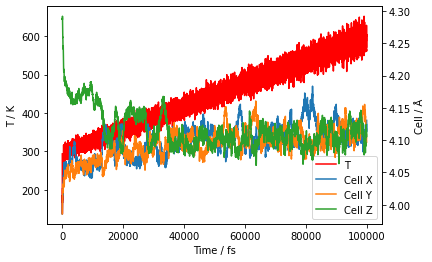

In [8]:
# import matplotlib.pyplot as plt
# from ase.io import Trajectory
# tag = "./output/BaTiO3_tetragonal_NPT"

traj = Trajectory(tag+".traj")
x = [ss.cell.cellpar()[0] / 4 for ss in traj] 
y = [ss.cell.cellpar()[1] / 4 for ss in traj] 
z = [ss.cell.cellpar()[2] / 4 for ss in traj] 
t = [1.0 * i for i in range(len(x))]
temp = [ss.get_temperature() for ss in traj]
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx()

ax1.plot(t,temp,label="T", color="red")

ax2.plot(t,x,label="Cell X")
ax2.plot(t,y,label="Cell Y")
ax2.plot(t,z,label="Cell Z")


ax1.set_xlabel("Time / fs")
ax2.set_ylabel("Cell / Å")
ax1.set_ylabel("T / K")
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

ax1.legend(h1+h2, l1+l2, loc='lower right')
fig.show()

Cubic : [16.49943864 16.38873524 16.42598681 90.00004028 89.99995033 90.00000356]
Tetragonal : [16.22180295 16.177742   16.74072992 90.00004028 89.99995033 90.00000356]


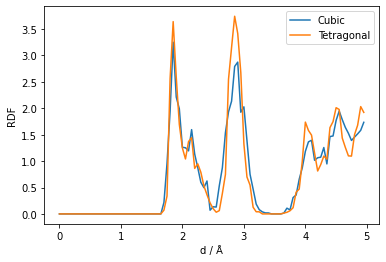

In [9]:
# from ase.geometry.analysis import Analysis

atoms1 = traj[-10]
atoms2 = traj[1000]    # MD計算が安定した頃のタイムステップから構造を抽出しています
tags = ["Cubic", "Tetragonal"]
rmax = 5
nbins = 100
delta = [(rmax/nbins)*i for i in range(nbins)]
for bto, name in zip([atoms1, atoms2], tags):
    atoms = bto.copy()
    print(name, ":",atoms.cell.cellpar())
    #atoms *= (4,4,4)
    ana = Analysis(atoms)
    rdf = ana.get_rdf(rmax,nbins,elements=["Ti","O"])[0]
    plt.plot(delta, rdf, label=name)
plt.xlabel("d / Å")
plt.ylabel("RDF")
plt.legend()
plt.show()

Tetragonalを初期構造としてMD計算を行うことで
- 400K 周辺で格子定数が同じ値に近づく（＝cubicへの相転移が確認できる）
- tetragonal構造はRDFの2Å付近で3か所のピークに分かれる
- cubic構造もMD計算でRDFピークは広がりを見せる

ことを確認して本事例の説明を終えます。